# **Desafio Cientista de Dados Indicium**

No presente relatório se encontram duas das entregas do desafio. A primeira seção se trata de uma **Exploratory Data Analysis**, onde serão analisadas as relações entre os dados e o impacto das mesmas no target (salário anual). Na segunda seção serão discutidos os **códigos utilizados**, desde sua escolha até seus resultados. 

## Exploratory Data Analysis

### Import de bibliotecas


In [89]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn import preprocessing, metrics, tree
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="ticks", color_codes=True)

### Carregamento da base de dados


Ao executar os trechos de código abaixo, é possível observar como
o nosso conjunto de dados se parece e suas principais informações. As features são age, workclass, fnlwgt, education, education_num, 
marital_status, occupation, relationship, race, sex, capital_gain, capital_loss, hours_per_week e native_country. O conjunto de dados não possui valores nulos.

In [90]:
dataset = pd.read_csv("wage_train.csv", skipinitialspace = True)
dataset = dataset.drop(columns=['Unnamed: 0'])

dataset.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,yearly_wage
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


In [91]:
# Informações sobre a base de dados
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32560 entries, 0 to 32559
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32560 non-null  int64 
 1   workclass       32560 non-null  object
 2   fnlwgt          32560 non-null  int64 
 3   education       32560 non-null  object
 4   education_num   32560 non-null  int64 
 5   marital_status  32560 non-null  object
 6   occupation      32560 non-null  object
 7   relationship    32560 non-null  object
 8   race            32560 non-null  object
 9   sex             32560 non-null  object
 10  capital_gain    32560 non-null  int64 
 11  capital_loss    32560 non-null  int64 
 12  hours_per_week  32560 non-null  int64 
 13  native_country  32560 non-null  object
 14  yearly_wage     32560 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


### Estatísticas descritivas

#### Workclass e occupation


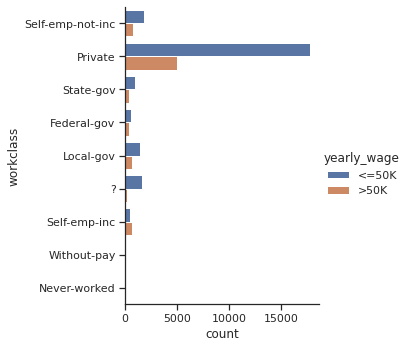

In [92]:
sns.catplot(y="workclass", hue="yearly_wage", kind="count", data=dataset)

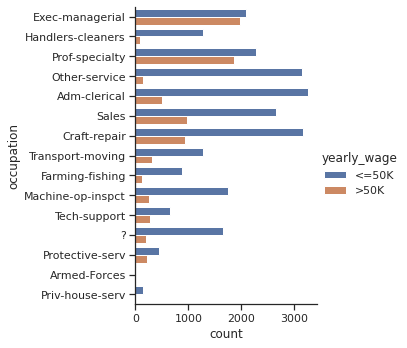

In [93]:
sns.catplot(y="occupation", hue="yearly_wage", kind="count", data=dataset)

Essas duas features também mostram informações bastante claras sobre nosso conjunto de dados. Podemos observar que a probabilidade de alguém com a workclass "private" ter renda <= 50 mil é muito maior do que o contrário. Essa workclass é a mais comum em nosso dataset. 
No gráfico de Occupation, vemos que algumas profissões possuem uma probabilidade grande de ter um salário maior que 50 mil, como a exec-managerial. Esses casos em que a probabilidade está quase 50-50 serão mais dificeis de prever do que individuos que responderam "other-service", por exemplo. Encontrar os individuos com a renda maior que 50 mil será mais desafiador do que o contrário, o que provavélmente refletirá nos resultados.

#### Education

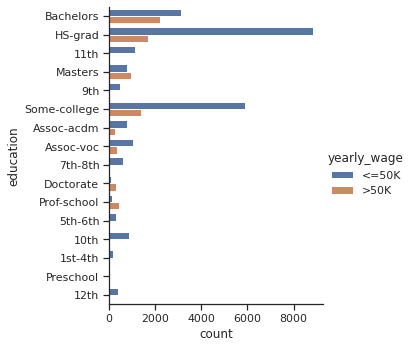

In [94]:
sns.catplot(y="education", hue="yearly_wage", kind="count", data=dataset)

Há uma relação clara entre a educação e o salário anual. Quanto menor a educação, menor a porcentagem de indivíduos com renda maior que 50 mil. Isso mostra que essa feature tem grande impacto.

#### Sex e race

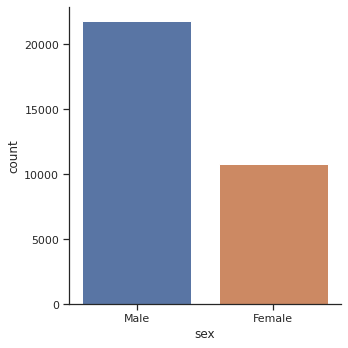

In [95]:
sns.catplot(x='sex',data=dataset,kind='count')

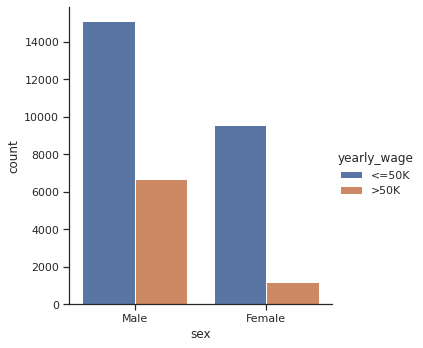

In [96]:
sns.catplot(x="sex", hue="yearly_wage", kind='count', data=dataset)

Nosso conjunto de dados tem mais entradas de pessoas do sexo masculino. Além disso, a porcentagem de homens com a renda maior que 50 mil é muito maior do que a porcentagem de mulheres.

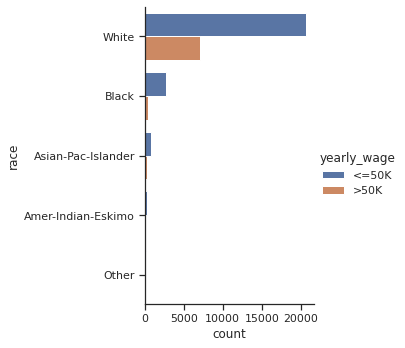

In [97]:
sns.catplot(y="race", hue="yearly_wage", kind="count", data=dataset)

Nosso conjunto de dados possui mais entradas de pessoas brancas. A proporção de péssoas com renda maior que 50 mil é maior para as pessoas brancas do que para as de outras etnias.

## Pré-processamento e transformação dos dados


---



### Procedimentos

In [111]:
# Função para substituir valores inválidos no conjunto de dados
def replace_invalid_values(dataset):
  # Substitui os pontos de interrogação encontrados na base de dados
  # O novo tipo do dado será NaN
  for col in dataset.columns:
      dataset[col].replace({'?':np.nan},inplace=True)

  # Encontra a soma de valores nulos por coluna 
  dataset.isnull().sum()

  # Separa as colunas com valores nulos
  missing_value_cols = ['workclass', 'occupation',  'native_country']

  # Substituição dos nulos pela moda
  '''O método foi escolhido por ser adequado para alfanuméricos e
  facilitar o processamento de dados'''
  for col in missing_value_cols:
      dataset[col].fillna(dataset[col].mode()[0], inplace=True)

  # O dataset está livre de dados inválidos
  dataset.isnull().sum()

  return dataset

In [112]:
def feature_scaling(dataset):
  # Separa as categorias com valores alfanuméricos
  columns_category = ['workclass', 'education', 'marital_status', 'occupation', 
                      'relationship', 'race', 'sex', 'native_country', 'yearly_wage']

  # Transforma os valores em valores entre 0 e 1
  le = preprocessing.LabelEncoder()
  for col in columns_category:
    le.fit(dataset[col])
    dataset[col] = le.fit_transform(dataset[col])

  '''Reescala os valores para que não haja discrepância de importância entre
  as features e para facilitar o processamento dos dados'''
  dataset_normalize = dataset.copy()
  dataset_normalize[dataset.columns] = preprocessing.MinMaxScaler().fit_transform(dataset[dataset.columns])

  dataset = dataset_normalize

  return dataset

### Visualização


In [113]:
# Realiza processamento
dataset = replace_invalid_values(dataset)
dataset = feature_scaling(dataset)

# Nova visualização dos dados
dataset.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,yearly_wage
0,0.452055,0.714286,0.048238,0.600000,0.800000,0.333333,0.230769,0.0,1.0,1.0,0.0,0.0,0.122449,0.95,0.0
1,0.287671,0.428571,0.138113,0.733333,0.533333,0.000000,0.384615,0.2,1.0,1.0,0.0,0.0,0.397959,0.95,0.0
2,0.493151,0.428571,0.151068,0.066667,0.400000,0.333333,0.384615,0.0,0.5,1.0,0.0,0.0,0.397959,0.95,0.0
3,0.150685,0.428571,0.221488,0.600000,0.800000,0.333333,0.692308,1.0,0.5,0.0,0.0,0.0,0.397959,0.10,0.0
4,0.273973,0.428571,0.184932,0.800000,0.866667,0.333333,0.230769,1.0,1.0,0.0,0.0,0.0,0.397959,0.95,0.0


## Análise de Métodos

---



O **Random Forest** é um algoritimo de classificação que consite de diversas Decision Trees, ele usa **bagging** (bootstrapping + aggregation) e seleciona **features aleatórias** (sqrt(num_features) por árvore) para criar decision trees. Cada árvore dá sua predição baseando-se nas features que lhe foram dadas. O resultado final é a **predição mais comum** entre todas as trees da floresta.

Escolhi esse método porque nosso conjunto de dados possui diversas relações entre as features que precisam ser levadas em consideração. O Random Forest faz essa análise com excelência, explorando diversas combinações de colunas (100 trees no total).

Por fim, trouxe abaixo mais três métodos (SVC, Decision Tree e KNN) para compararmos o resultado. É possível rodar todos os testes em "Execução".

**O Random Forest obteve resultados mais satisfatórios em todas as categorias**, com destaque na predição de yearly_wages maiores que 50k, onde houve melhora significativa. 

### Execução

#### K-Nearest Neighbour

In [124]:
def knn_classifier(dataset):

  # Splitting data
  # Optei pela divisão 80/20
  training_set, test_set = train_test_split(dataset, test_size = 0.2, random_state = 1)

  # Separando targets
  X_train = training_set.iloc[:,0:14].values
  Y_train = training_set.iloc[:,14].values
  X_test = test_set.iloc[:,0:14].values
  Y_test = test_set.iloc[:,14].values

  # Implementando algoritmo
  classifier = KNeighborsClassifier()
  classifier.fit(X_train,Y_train)
  Y_pred = classifier.predict(X_test)

  # Métricas
  print('Resultados para o método K-Nearest Neighbour Classifier')
  print(metrics.classification_report(Y_test, Y_pred))


#### Decision Tree

In [125]:
def decision_tree_classifier(dataset):

  # Splitting data
  # Optei pela divisão 80/20
  training_set, test_set = train_test_split(dataset, test_size = 0.2, random_state = 1)

  # Separando targets
  X_train = training_set.iloc[:,0:14].values
  Y_train = training_set.iloc[:,14].values
  X_test = test_set.iloc[:,0:14].values
  Y_test = test_set.iloc[:,14].values

  # Implementando algoritmo
  classifier = tree.DecisionTreeClassifier()
  classifier.fit(X_train,Y_train)
  Y_pred = classifier.predict(X_test)

  # Métricas
  print('Resultados para o método Decision Tree Classifier')
  print(metrics.classification_report(Y_test, Y_pred))


#### Random Forest

In [126]:
def random_forest_classifier(dataset):

  # Splitting data
  # Optei pela divisão 80/20
  training_set, test_set = train_test_split(dataset, test_size = 0.2, random_state = 1)

  # Separando targets
  X_train = training_set.iloc[:,0:14].values
  Y_train = training_set.iloc[:,14].values
  X_test = test_set.iloc[:,0:14].values
  Y_test = test_set.iloc[:,14].values

  # Implementando algoritmo
  classifier = RandomForestClassifier()
  classifier.fit(X_train,Y_train)
  Y_pred = classifier.predict(X_test)

  # Métricas
  print('Resultados para o método Random Forest Classifier')
  print(metrics.classification_report(Y_test, Y_pred))


#### SVC

In [127]:
def support_vector_classification(dataset):

  # Splitting data
  # Optei pela divisão 80/20
  training_set, test_set = train_test_split(dataset, test_size = 0.2, random_state = 1)

  # Separando targets
  X_train = training_set.iloc[:,0:14].values
  Y_train = training_set.iloc[:,14].values
  X_test = test_set.iloc[:,0:14].values
  Y_test = test_set.iloc[:,14].values

  # Implementando algoritmo
  classifier = SVC()
  classifier.fit(X_train,Y_train)
  Y_pred = classifier.predict(X_test)

  # Métricas
  print(f'Resultados para o método SVC:')
  print(metrics.classification_report(Y_test, Y_pred))


#### Main

In [128]:
support_vector_classification(dataset)
decision_tree_classifier(dataset)
knn_classifier(dataset)
random_forest_classifier(dataset)

Resultados para o método SVC:
              precision    recall  f1-score   support

         0.0       0.87      0.94      0.90      4990
         1.0       0.74      0.52      0.61      1522

    accuracy                           0.85      6512
   macro avg       0.80      0.73      0.76      6512
weighted avg       0.84      0.85      0.84      6512

Resultados para o método Decision Tree Classifier
              precision    recall  f1-score   support

         0.0       0.88      0.88      0.88      4990
         1.0       0.60      0.60      0.60      1522

    accuracy                           0.81      6512
   macro avg       0.74      0.74      0.74      6512
weighted avg       0.81      0.81      0.81      6512

Resultados para o método K-Nearest Neighbour Classifier
              precision    recall  f1-score   support

         0.0       0.88      0.91      0.89      4990
         1.0       0.66      0.58      0.62      1522

    accuracy                           0.83   

# Aplicação final na base de dados de teste


In [129]:
import pandas as pd
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier

def replace_invalid_values(dataset):
    missing_value_cols = ['workclass', 'occupation',  'native_country']

    for col in missing_value_cols:
        dataset[col].fillna(dataset[col].mode()[0], inplace=True)

    return dataset

def feature_scaling(dataset, columns_category):
    le = preprocessing.LabelEncoder()
    for col in columns_category:
        le.fit(dataset[col])
        dataset[col] = le.fit_transform(dataset[col])

    dataset_normalize = dataset.copy()
    dataset_normalize[dataset.columns] = preprocessing.MinMaxScaler().fit_transform(dataset[dataset.columns])

    dataset = dataset_normalize

    return dataset

def main():
    # Carregamento
    training_set = pd.read_csv("wage_train.csv", skipinitialspace = True)
    test_set = pd.read_csv("wage_test.csv", skipinitialspace = True)
    training_set = training_set.drop(columns=['Unnamed: 0'])
    test_set = test_set.drop(columns=['Unnamed: 0'])

    # Preprocessamento
    training_set = replace_invalid_values(training_set)
    test_set = replace_invalid_values(test_set)
    columns_category = ['workclass', 'education', 'marital_status', 'occupation', 
                    'relationship', 'race', 'sex', 'native_country', 'yearly_wage']
    training_set = feature_scaling(training_set, columns_category)
    columns_category = ['workclass', 'education', 'marital_status', 'occupation', 
                        'relationship', 'race', 'sex', 'native_country']
    test_set = feature_scaling(test_set, columns_category)
    
    # Separando target de trainamento
    X_train = training_set.iloc[:,0:14].values
    Y_train = training_set.iloc[:,14].values
    
    # Implementando Random Forest
    classifier = RandomForestClassifier()
    classifier.fit(X_train,Y_train)
    prediction = classifier.predict(test_set)
    
    # Convertendo para csv
    results = pd.DataFrame(prediction, columns = ['predictedValues'])
    results.to_csv('predicted.csv')
    
main()

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
